In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta

In [ ]:
sales_train_validation = pd.read_csv('sales_train_validation.csv')
sales_train_evaluation = pd.read_csv('sales_train_evaluation.csv')
sell_prices = pd.read_csv('sell_prices.csv')
calendar = pd.read_csv('calendar.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [ ]:
calendar['date'] = pd.to_datetime(calendar['date'])

In [ ]:
calendar['combined_event_type'] = calendar.apply(
    lambda row: row['event_type_1'] if pd.isnull(row['event_type_2'])
    else row['event_type_1'] + ' & ' + row['event_type_2'],
    axis=1
)

In [ ]:
'''Data pre-processing - Filtering top 10 products by category'''

'Data pre-processing'

In [ ]:
item_category_sales = sales_train_validation.groupby(['item_id', 'cat_id']).sum().iloc[:, -1913:].sum(axis=1).reset_index()

item_category_sales.columns = ['item_id', 'cat_id', 'total_sales']

top_10_per_category = item_category_sales.sort_values(['cat_id', 'total_sales'], ascending=[True, False]).groupby('cat_id').head(10)

sales_train_validation = sales_train_validation.loc[sales_train_validation['item_id'].isin(top_10_per_category['item_id'])]
sales_train_evaluation = sales_train_evaluation.loc[sales_train_evaluation['item_id'].isin(top_10_per_category['item_id'])]

<ipython-input-6-cd941252ab85>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  item_category_sales = sales_train_validation.groupby(['item_id', 'cat_id']).sum().iloc[:, -1913:].sum(axis=1).reset_index()


In [ ]:
# Melt sales data to long format
sales_train_validation = pd.melt(sales_train_validation, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='day', value_name='sales')
sales_train_validation['day'] = sales_train_validation['day'].apply(lambda x: x[2:]).astype(int)

data = pd.merge(sales_train_validation, calendar, left_on='day', right_on=calendar['d'].apply(lambda x: x[2:]).astype(int), how='left')

data['date'] = pd.to_datetime(data['date'])
data = pd.merge(data, sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

In [ ]:
#Same for Evaluation Dataset
sales_train_evaluation = pd.melt(sales_train_evaluation, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='day', value_name='sales')
sales_train_evaluation['day'] = sales_train_evaluation['day'].apply(lambda x: x[2:]).astype(int)
eval_data = pd.merge(sales_train_evaluation, calendar, left_on='day', right_on=calendar['d'].apply(lambda x: x[2:]).astype(int), how='left')
eval_data['date'] = pd.to_datetime(eval_data['date'])
eval_data = pd.merge(eval_data, sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

In [ ]:
# Create a list of all the event/holiday columns
event_columns = [col for col in data.columns if 'event' in col]

# Create a new column 'is_event_or_holiday' that is True if any event/holiday is True, False otherwise
data['is_event_or_holiday'] = data[event_columns].any(axis=1)
eval_data['is_event_or_holiday'] = eval_data[event_columns].any(axis=1)

In [ ]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

data['weekday'] = pd.Categorical(data['weekday'], categories=days_order, ordered=True)
eval_data['weekday'] = pd.Categorical(eval_data['weekday'], categories=days_order, ordered=True)

In [ ]:
data.sort_values(by=['id', 'date'], inplace=True)
eval_data.sort_values(by=['id', 'date'], inplace=True)

In [ ]:
''' Group and Create Lagged Features
data['sales_lag_1'] = data.groupby(['id'])['sales'].shift(1)
data['sales_lag_7'] = data.groupby(['id'])['sales'].shift(7)
data['sales_lag_30'] = data.groupby(['id'])['sales'].shift(30)

eval_data['sales_lag_1'] = eval_data.groupby(['id'])['sales'].shift(1)
eval_data['sales_lag_7'] = eval_data.groupby(['id'])['sales'].shift(7)
eval_data['sales_lag_30'] = eval_data.groupby(['id'])['sales'].shift(30)

data['sales_rolling_mean_7'] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(7).mean())
data['sales_rolling_mean_28'] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(28).mean())
data['sales_rolling_std_7'] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(7).std())
data['sales_rolling_std_28'] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(28).std())

eval_data['sales_rolling_mean_7'] = eval_data.groupby(['id'])['sales'].transform(lambda x: x.rolling(7).mean())
eval_data['sales_rolling_mean_28'] = eval_data.groupby(['id'])['sales'].transform(lambda x: x.rolling(28).mean())
eval_data['sales_rolling_std_7'] = eval_data.groupby(['id'])['sales'].transform(lambda x: x.rolling(7).std())
eval_data['sales_rolling_std_28'] = eval_data.groupby(['id'])['sales'].transform(lambda x: x.rolling(28).std())

chunk_size = 100000
num_chunks = len(data) // chunk_size + 1

processed_data = []

for i in range(num_chunks):
    start_index = i * chunk_size
    end_index = (i + 1) * chunk_size
    chunk = data.iloc[start_index:end_index].copy()

    # Apply the operation on the chunk
    chunk.dropna(subset=['sales_lag_30'], inplace=True)

    # You can then save this chunk to a new dataframe or a list
    processed_data.append(chunk)

data = pd.concat(processed_data, ignore_index=True)

chunk_size = 100000
num_chunks = len(eval_data) // chunk_size + 1

processed_data = []

for i in range(num_chunks):
    start_index = i * chunk_size
    end_index = (i + 1) * chunk_size
    chunk = eval_data.iloc[start_index:end_index].copy()

    # Apply the operation on the chunk
    chunk.dropna(subset=['sales_lag_30'], inplace=True)

    # You can then save this chunk to a new dataframe or a list
    processed_data.append(chunk)

eval_data = pd.concat(processed_data, ignore_index=True)

'''

In [ ]:
data['start_of_month'] = (data['date'].dt.day == 1).astype(int)
data['is_august'] = (data['month'] == 8).astype(int)

#Evaluation dataset
eval_data['start_of_month'] = (eval_data['date'].dt.day == 1).astype(int)
eval_data['is_august'] = (eval_data['month'] == 8).astype(int)

In [ ]:
data['snap_CA_sales'] = np.where(data['state_id'] == 'CA', data['snap_CA'] * data['sales'], 0)
data['snap_TX_sales'] = np.where(data['state_id'] == 'TX', data['snap_TX'] * data['sales'], 0)
data['snap_WI_sales'] = np.where(data['state_id'] == 'WI', data['snap_WI'] * data['sales'], 0)

#Evaluation Dataset
eval_data['snap_CA_sales'] = np.where(eval_data['state_id'] == 'CA', eval_data['snap_CA'] * eval_data['sales'], 0)
eval_data['snap_TX_sales'] = np.where(eval_data['state_id'] == 'TX', eval_data['snap_TX'] * eval_data['sales'], 0)
eval_data['snap_WI_sales'] = np.where(eval_data['state_id'] == 'WI', eval_data['snap_WI'] * eval_data['sales'], 0)

In [ ]:
#Grabbing only the last 28 days by product
eval_data = eval_data.groupby('id').apply(lambda x: x.tail(28))
eval_data.reset_index(drop=True, inplace=True)

In [ ]:
categorical_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'combined_event_type']
for col in categorical_columns:
    data[col] = data[col].astype('category').cat.codes

In [ ]:
categorical_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'combined_event_type']
for col in categorical_columns:
    eval_data[col] = eval_data[col].astype('category').cat.codes

In [ ]:
'''LightGBM Model'''

'LightGBM Model'

In [ ]:
products = data['id'].unique()

start_time = datetime.datetime.now()

all_results = []
all_results_train = []
all_results_future = []

for i, product in enumerate(products):


    product_data = data[data['id'] == product]
    product_data = product_data.drop('date', axis=1)


    X_future = eval_data[eval_data['id'] == product]
    future_dates_sales = X_future[['date', 'sales']]
    X_future = X_future.drop(['date','sales'], axis=1)

    X = product_data.drop('sales', axis=1)
    y = product_data['sales']

    X_train, X_valid = X[:-180], X[-180:]
    y_train, y_valid = y[:-180], y[-180:]


    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)


    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 7,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'verbose': 0, 
        'early_stopping_rounds': 10
    }

    num_round = 1000
    bst = lgb.train(params, train_data, num_round, valid_sets=[valid_data])

    predictions = bst.predict(X_valid)

    future_predictions = bst.predict(X_future)

    predictions_train = bst.predict(X_train)

    mae_train = mean_absolute_error(y_train, predictions_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))

    results_df = pd.DataFrame({
        'item_id': product,
        'actual': y_valid.values,
        'predicted': predictions
    })

    results_train = pd.DataFrame({
        'item_id': product,
        'actual': y_train.values,
        'predicted': predictions_train
    })

    future_results_df = pd.DataFrame({
        'item_id': product,
        'date': future_dates_sales['date'],
        'actual': future_dates_sales['sales'],
        'predicted_sales': future_predictions
    })

    all_results.append(results_df)
    all_results_train.append(results_train)
    all_results_future.append(future_results_df)


final_results_df = pd.concat(all_results, axis=0, ignore_index=True)
final_results_train_df = pd.concat(all_results_train, axis=0, ignore_index=True)
final_results_future_df = pd.concat(all_results_future, axis=0, ignore_index=True)


end_time = datetime.datetime.now()
duration = end_time - start_time
print('Total time taken:', duration.total_seconds() / 60, 'minutes')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You 

In [ ]:
duration

datetime.timedelta(seconds=20, microseconds=333284)

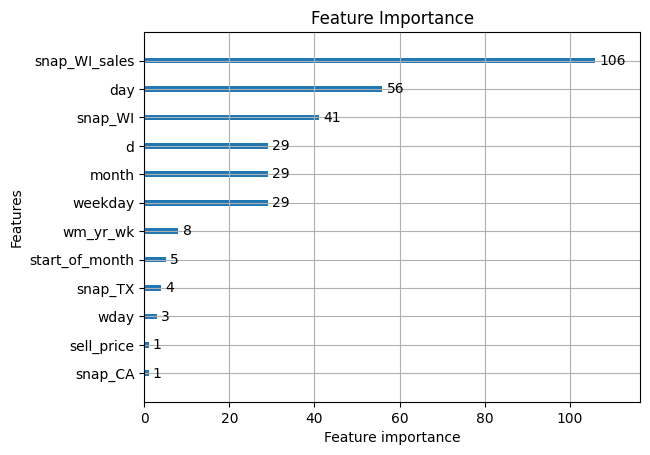

In [ ]:
#Plot Feature Importance
lgb.plot_importance(bst, importance_type='split')
plt.title('Feature Importance')
plt.show()

In [ ]:
final_results_future_df

,item_id,date,actual,predicted_sales
0,0,2016-04-25,48,32.893489
1,0,2016-04-26,35,32.893489
2,0,2016-04-27,34,32.893489
3,0,2016-04-28,67,32.893489
4,0,2016-04-29,63,41.383913
...,...,...,...,...
8395,299,2016-05-18,0,4.340514
8396,299,2016-05-19,5,4.340514
8397,299,2016-05-20,9,5.282888
8398,299,2016-05-21,5,5.348172


In [ ]:
last_180_dates = data['date'].tail(180).values

repeated_dates = np.tile(last_180_dates, data['id'].nunique())

unique_products = eval_data['id'].unique()
product_ids = np.repeat(unique_products, 180)

In [ ]:
final_results_df['date'] = repeated_dates

In [ ]:
grouped_eval_data = data.groupby('date')['sales'].sum().reset_index()
grouped_eval_data.columns = ['date', 'actual_sales']
grouped_predicted_data = final_results_df.groupby('date')['predicted'].sum().reset_index()

In [ ]:
merged_data = pd.merge(grouped_predicted_data, grouped_eval_data, on='date', how='left')

In [ ]:
grouped_future_data = final_results_future_df.groupby('date')['predicted_sales','actual'].sum().reset_index()

<ipython-input-27-0666d52132c7>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_future_data = final_results_future_df.groupby('date')['predicted_sales','actual'].sum().reset_index()


In [ ]:
merged_data.head()

,date,predicted,actual_sales
0,2015-10-28,13723.619161,12155
1,2015-10-29,13856.366868,13157
2,2015-10-30,15058.332675,16682
3,2015-10-31,17056.087842,17374
4,2015-11-01,18632.550367,18336


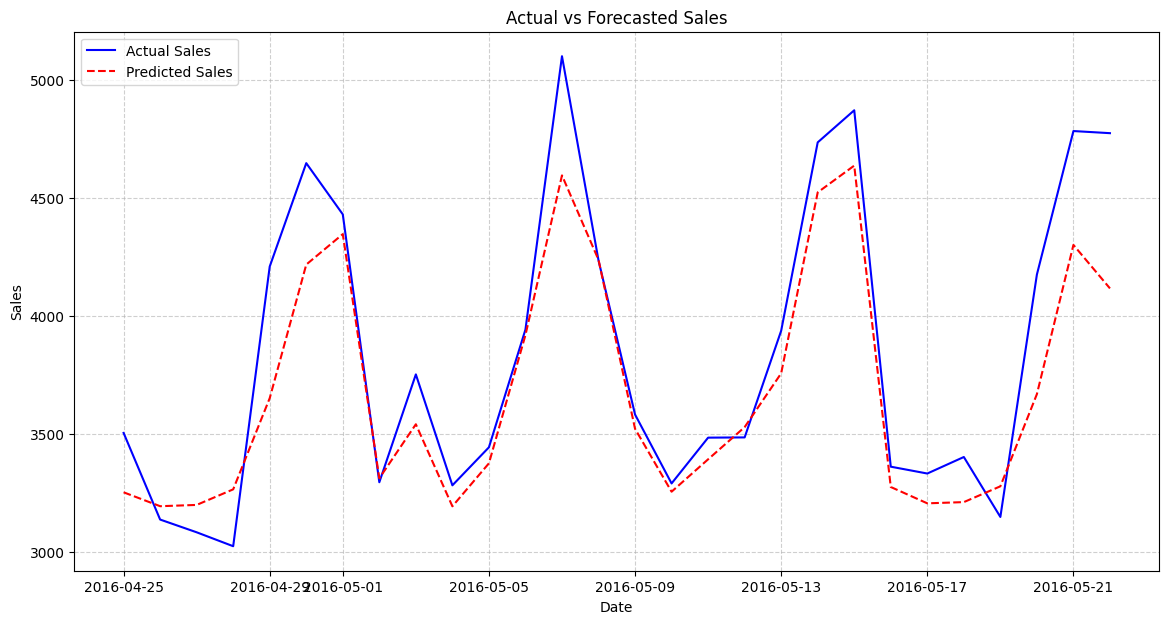

In [ ]:
plt.figure(figsize=(14, 7))

plt.plot(grouped_future_data['date'], grouped_future_data['actual'], label='Actual Sales', color='blue')

plt.plot(grouped_future_data['date'], grouped_future_data['predicted_sales'], label='Predicted Sales', color='red', linestyle='--')

plt.title('Actual vs Forecasted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


In [ ]:
# Compute RMSE
rmse = np.sqrt(mean_squared_error(final_results_df['actual'], final_results_df['predicted']))
print('Overall RMSE:', rmse)

# Compute MAE
mae = mean_absolute_error(final_results_df['actual'], final_results_df['predicted'])
print('Overall MAE:', mae)

Overall RMSE: 7.672076130322847
Overall MAE: 4.200112408426956


In [ ]:
# Compute RMSE
rmse = np.sqrt(mean_squared_error(final_results_train_df['actual'], final_results_train_df['predicted']))
print('Overall RMSE:', rmse)

# Compute MAE
mae = mean_absolute_error(final_results_train_df['actual'], final_results_train_df['predicted'])
print('Overall MAE:', mae)

Overall RMSE: 8.04041229182601
Overall MAE: 4.034945838911031


In [ ]:
# Compute RMSE
rmse = np.sqrt(mean_squared_error(final_results_future_df['actual'], final_results_future_df['predicted_sales']))
print('Overall RMSE:', rmse)

# Compute MAE
mae = mean_absolute_error(final_results_future_df['actual'], final_results_future_df['predicted_sales'])
print('Overall MAE:', mae)

Overall RMSE: 7.142999380425258
Overall MAE: 4.333519053126805


In [ ]:
final_results_df.to_excel("LightGBM_results.xlsx", index=False, engine='openpyxl')

In [ ]:
from google.colab import files

# Trigger the file download
files.download("LightGBM_results.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>